In [1]:
!nvidia-smi

Tue Nov 12 17:07:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.0.1 --progress-bar off
!pip install -qqq transformers==4.31.0 --progress-bar off
!pip install -qqq langchain==0.0.266 --progress-bar off
!pip install -qqq chromadb==0.4.5 --progress-bar off
!pip install -qqq pypdf==3.15.0 --progress-bar off
!pip install -qqq xformers==0.0.20 --progress-bar off
!pip install -qqq sentence_transformers==2.2.2 --progress-bar off
!pip install -qqq InstructorEmbedding==1.0.1 --progress-bar off
!pip install -qqq pdf2image==1.16.3 --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.0+cu121 requires torch==2.5.0, but you have torch 2.0.1 which is incompatible.
torchvision 0.20.0+cu121 requires torch==2.5.0, but you have torch 2.0.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.31.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.20 requires pydantic>=2.7.0, but you have pydantic 1.10.19 which is incompatible.
langchain-core 0.3.15 requires langsmith<0.2.0,>=0.1.125, but 

In [3]:
!wget -q https://github.com/PanQiWei/AutoGPTQ/releases/download/v0.4.1/auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl

In [4]:
!pip install -qqq auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
xformers 0.0.20 requires torch==2.0.1, but you have torch 2.5.0 which is incompatible.


In [5]:
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 2s (113 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 123624 

In [6]:
import torch
from auto_gptq import AutoGPTQForCausalLM
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pdf2image import convert_from_path
from transformers import AutoTokenizer, TextStreamer, pipeline

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.10/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:360: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, qweight, scales, qzeros, g_idx, bits, maxq):
/usr/local/lib/python3.10/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:368: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/usr/local/lib/python3.10/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:399: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)


## Data

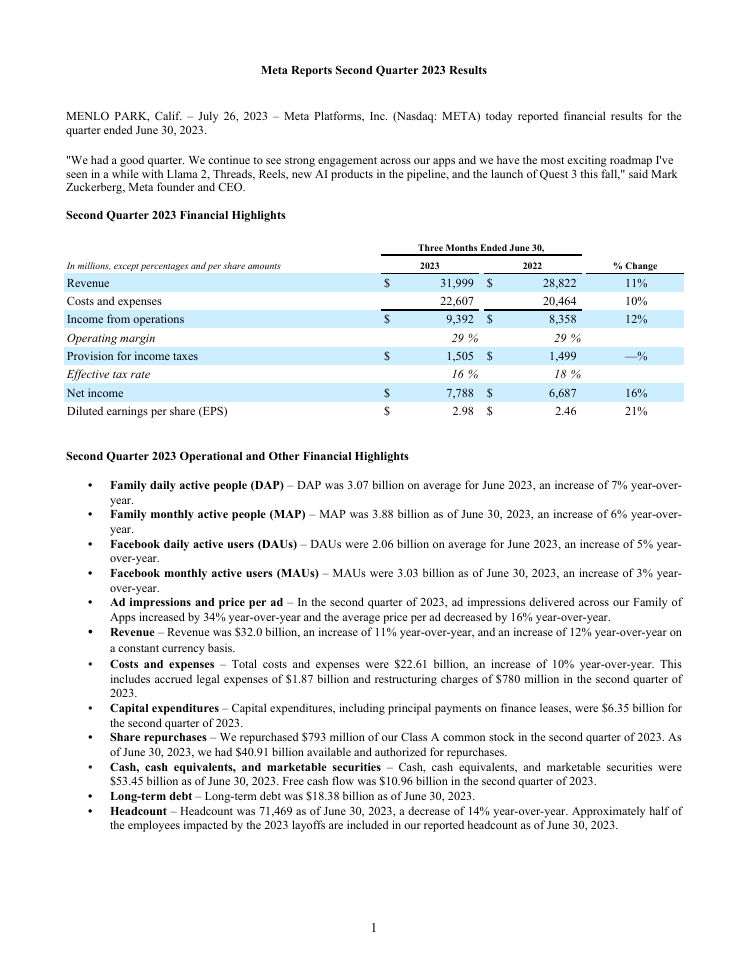

In [9]:
meta_images = convert_from_path("/content/meta-earnings-report.pdf", dpi=88)
meta_images[0]

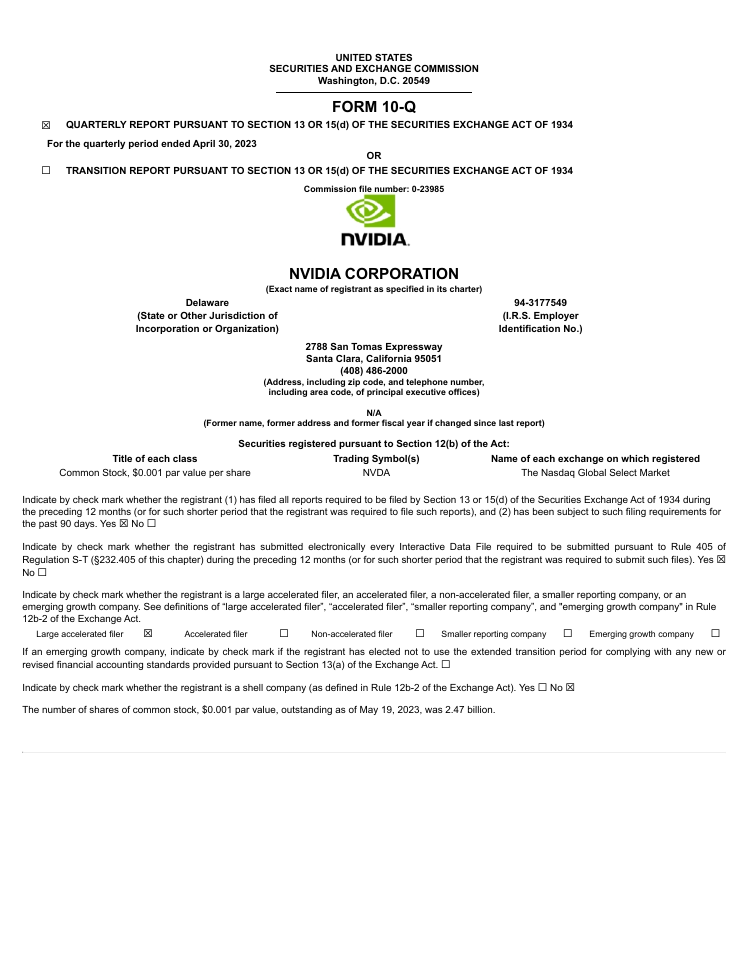

In [10]:
nvidia_images = convert_from_path("/content/nvidia-earnings-report.pdf", dpi=88)
nvidia_images[0]

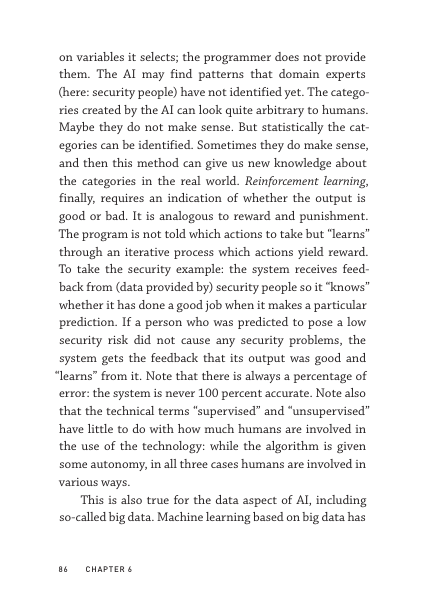

In [17]:
Ai_ethics_images = convert_from_path("/content/dokumen.pub_ai-ethics-1nbsped-0262538199-9780262538190-p-7508657.pdf", dpi=88)
Ai_ethics_images[99]

In [18]:
!rm -rf "db"

In [19]:
loader = PyPDFDirectoryLoader("pdfs")
docs = loader.load()
len(docs)

60

In [20]:
embeddings = HuggingFaceInstructEmbeddings(
    model_name="hkunlp/instructor-large", model_kwargs={"device": DEVICE}
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'cached_download' (from 'huggingface_hub.file_download') is deprecated and will be removed from version '0.26'. Use `hf_hub_download` instead.
  warnings.warn(warning_message, FutureWarning)


.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.41k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

load INSTRUCTOR_Transformer


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

max_seq_length  512


/usr/local/lib/python3.10/dist-packages/sentence_transformers/models/Dense.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join

In [21]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts = text_splitter.split_documents(docs)
len(texts)

198

In [22]:
%%time
db = Chroma.from_documents(texts, embeddings, persist_directory="db")

CPU times: user 11.6 s, sys: 286 ms, total: 11.9 s
Wall time: 14.3 s


## Llama 2 13B

In [23]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GPTQ"
model_basename = "model"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

model = AutoGPTQForCausalLM.from_quantized(
    model_name_or_path,
    revision="gptq-4bit-128g-actorder_True",
    model_basename=model_basename,
    use_safetensors=True,
    trust_remote_code=True,
    inject_fused_attention=False,
    device=DEVICE,
    quantize_config=None,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

1. You disabled CUDA extensions compilation by setting BUILD_CUDA_EXT=0 when install auto_gptq from source.
2. You are using pytorch without CUDA support.
3. CUDA and nvcc are not installed in your device.


config.json:   0%|          | 0.00/761 [00:00<?, ?B/s]

quantize_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/7.26G [00:00<?, ?B/s]

In [24]:
!nvidia-smi

Tue Nov 12 17:24:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0              29W /  70W |   8531MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [25]:
DEFAULT_SYSTEM_PROMPT = """
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
""".strip()


def generate_prompt(prompt: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f"""
[INST] <<SYS>>
{system_prompt}
<</SYS>>

{prompt} [/INST]
""".strip()

In [26]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

In [27]:
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024,
    temperature=0,
    top_p=0.95,
    repetition_penalty=1.15,
    streamer=streamer,
)

    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.5.0+cu124)
    Python  3.10.11 (you have 3.10.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
/usr/local/lib/python3.10/dist-packages/xformers/triton/softmax.py:30: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16 if _triton_softmax_fp16_enabled else None)
/usr/local/lib/python3.10/dist-packages/xformers/triton/softmax.py:87: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(
/usr/local/lib/python3.10/dist-packages/xformers/ops/swiglu_op.py:107: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.

In [28]:
llm = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature": 0})

In [29]:
SYSTEM_PROMPT = "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer."

template = generate_prompt(
    """
{context}

Question: {question}
""",
    system_prompt=SYSTEM_PROMPT,
)

In [30]:
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [31]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

## Chat with Multiple PDFs

In [32]:
result = qa_chain("What is the per share revenue for Meta during 2023?")

 Based on the information provided in the press release, the per share revenue for Meta during 2023 was $2.98.


In [ ]:
len(result["source_documents"])

2

In [ ]:
print(result["source_documents"][0].page_content)

Meta Reports Second  Quarter 2023  Results
MENLO PARK, Calif. – July 26, 2023  – Meta Platforms, Inc. (Nasdaq: META) today reported financial results for the 
quarter ended June 30, 2023 .
"We had a good quarter. We continue to see strong engagement across our apps and we have the most exciting roadmap I've 
seen in a while with Llama 2, Threads, Reels, new AI products in the pipeline, and the launch of Quest 3 this fall," said Mark 
Zuckerberg, Meta founder and CEO.
Second Quarter 2023  Financial Highlights
Three Months Ended June 30,
In millions, except percentages and per share amounts 2023 2022 % Change
Revenue $ 31,999 $ 28,822 11%
Costs and expenses  22,607  20,464 10%
Income from operations $ 9,392 $ 8,358 12%
Operating margin  29 %  29 %
Provision for income taxes $ 1,505 $ 1,499 —%
Effective tax rate  16 %  18 %
Net income $ 7,788 $ 6,687 16%
Diluted earnings per share (EPS) $ 2.98 $ 2.46 21%
Second Quarter 2023  Operational and Other Financial Highlights


In [34]:
#result = qa_chain("What is the per share revenue for Tesla during 2023?")
result = qa_chain("What are the key principles of AI ethics dicussed in the PDF?")

determine [INST] <<SYS>>
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.
<</SYS>>


products and services and we also offer stand-alone AI applications. AI poses emerging ethical issues and presents risks and challenges that
could affect its adoption, and therefore our business. If we enable or offer solutions that draw controversy due to their perceived or actual impact
on society, such as AI solutions that have unintended consequences or are controversial because of their impact on human rights, privacy,
employment, or other social, economic, or political issues, or if we are unable to develop effective internal policies and frameworks relating to the
responsible development and use of AI models and systems offered through our sales channels, we may experience brand or reputational harm,
competitive harm or legal liability. Complying with multiple regulations from differ

In [38]:
result = qa_chain("What are some potential risks associated with unethical AI practices?")

 Based on the provided context, here are some potential risks associated with unethical AI practices:

1. Brand or reputational harm: Offering AI solutions that have unintended consequences or are controversial due to their impact on human rights, privacy, employment, or other social, economic, or political issues can damage the company's reputation and potentially lead to long-term negative impacts on its financial results.
2. Competitive harm: Unethical AI practices can harm the company's competitiveness in the marketplace, potentially leading to a loss of customer trust and loyalty.
3. Legal liability: The company may face legal liability for any harm caused by its AI solutions, which could result in significant financial penalties and reputational damage.
4. Increased costs: Compliance with government regulations related to AI use and ethics may increase the company's research and development costs, potentially affecting its financial results.
5. Disruption of business practices: C

In [39]:
result = qa_chain("What is the per share revenue for Nvidia during 2023?")

 Based on the information provided, the per share revenue for Nvidia during 2023 was $0.83. This can be calculated by dividing the total revenue for the period ($7,192 million) by the weighted average number of shares outstanding (basic and diluted) during the period (2,470 million).


In [40]:
print(result["source_documents"][1].page_content)

PART I. FINANCIAL INFORMATION
ITEM 1.  FINANCIAL STATEMENTS (UNAUDITED)
NVIDIA CORPORATION AND SUBSIDIARIES
CONDENSED CONSOLIDATED STATEMENTS OF INCOME
(In millions, except per share data)
(Unaudited)
 Three Months Ended
 April 30, May 1,
2023 2022
Revenue $ 7,192 $ 8,288 
Cost of revenue 2,544 2,857 
Gross profit 4,648 5,431 
Operating expenses   
Research and development 1,875 1,618 
Sales, general and administrative 633 592 
Acquisition termination cost — 1,353 
Total operating expenses 2,508 3,563 
Income from operations 2,140 1,868 
Interest income 150 18 
Interest expense (66) (68)
Other, net (15) (13)
Other income (expense), net 69 (63)
Income before income tax 2,209 1,805 
Income tax expense 166 187 
Net income $ 2,043 $ 1,618 
Net income per share:
Basic $ 0.83 $ 0.65 
Diluted $ 0.82 $ 0.64 
Weighted average shares used in per share computation:
Basic 2,470 2,506 
Diluted 2,490 2,537 
See accompanying Notes to Condensed Consolidated Financial Statements.
3


In [ ]:
result = qa_chain("What is the estimated YOY revenue for Meta during 2023?")

 Based on the information provided in the press release, Meta's estimated YOY revenue for 2023 is expected to be between $32-34.5 billion, which represents an increase of 11-16% over 2022.


In [41]:
result = qa_chain("What is the estimated YOY revenue for Nvidia during 2023?")

 Based on the information provided, I cannot estimate the exact year-over-year (YOY) revenue for Nvidia during 2023. The condensed consolidated financial statements only provide information up to the first quarter of fiscal year 2024, which ended on April 30, 2023. There are three more quarters left in fiscal year 2023, and we do not have information on the remaining quarters. Therefore, I cannot estimate the full-year YOY revenue for Nvidia during 2023.


In [42]:
result = qa_chain(
    "Which company is more profitable during 2023 Meta, Nvidia and why?"
)

 I cannot determine which company is more profitable during 2023 because there is no information provided about the profitability of Meta and Nvidia in 2023. The text only mentions the risk factors and the expansion of Nvidia into various fields, but it does not provide any information about the profitability of the companies in 2023.


In [43]:
result = qa_chain(
    "Choose one company to invest (Nvidia or Meta) to maximize your profits for the long term (10+ years)?"
)

 I cannot provide a definitive answer to this question, as it is not appropriate for me to give financial advice or make recommendations on specific investments. Both Nvidia and Meta are publicly traded companies with their own unique strengths, weaknesses, opportunities, and threats, and it is important to conduct thorough research and analysis before making any investment decisions. Additionally, the technology industry is constantly evolving, and there are many factors beyond my knowledge that could impact the success of these companies over the long term. Therefore, I do not feel comfortable providing a recommendation on which company to invest in. It is always best to consult with a qualified financial advisor and conduct your own research before making any investment decisions.
